# MixColumns/AddRoundKey1 Attack

The analysis for this attack is quite a bit more complicated than our usual CPA attacks. The big issue that we run into is that MixColumns, as the name suggests, combines the 4 bytes an AES state column together. Up to that point, each byte was completely independent of one another, meaning we could also evaluate each byte independently, turning a $2^{128}$ search into 16 $2^8$ searches. Now, with MixColumns, we need to evaluate 4 bytes at a time, giving us 4 $2^{32}$ searches. Does that mean if we cross a MixColumns in our leakage model, our attack is thwarted? Luckily, the answer to this is no! Instead of doing a full random plaintext like our usual attack, let's instead make all the bytes except the first 4 constant. Thanks to shift rows, that will give us 3 constant bytes and 1 variable byte in each column. MixColumns is the following operation ($v$ is the variable byte, $c_n$ are the constants). Note that the input of MixColumns is really just the output of SubBytes, our usual attack point, since ShiftRows doesn't modify the values, it just moves them:

$\left[\begin{array}{l}
d_{0} \\
d_{1} \\
d_{2} \\
d_{3}
\end{array}\right]=\left[\begin{array}{llll}
2 & 3 & 1 & 1 \\
1 & 2 & 3 & 1 \\
1 & 1 & 2 & 3 \\
3 & 1 & 1 & 2
\end{array}\right]\left[\begin{array}{l}
v \\
c_{1} \\
c_{2} \\
c_{3}
\end{array}\right]$

$d_0$, for example, will be:

$d_0 = 2v + 3c_1 + c_2 + c_3$

We can combine the three constants into a single constant:

$d_0 = 2v + c_a$

It might not be immediately obvious, but this has actually taken our $2^{32}$ attack down to $2^{16}$! If $c_a$ wasn't there, this would pretty much just be our regular CPA attack, so doing a CPA attack for each possible value of $c_a$ should allow us to to recover the key!

While this seems very promising, it does suffer from a few issues:

1. $2^{16}$ is still a fairly large search space, meaning our attack will take a very long time
1. $c$ is only being XOR'd here, which means we'll run into ghost peaks
1. This XOR also means the correct and incorrect values for $c$ will have very similar correlations.

Instead, we can attack $v$ one bit at a time. This is very similar to a single bit DPA attack, except we're still using correlation instead of the difference. Now the constant will only have the effect of inverting the correlation (if that constant bit is 1) or not inverting it (if that constant bit is 0). This means we can completely remove the effect of the constant by taking the absolute value of the correlation, taking us back to a $2^8$ attack! We also don't have to worry about the ghost peaks or the similar correlations for $c_a$.

As you might expect, on its own this attack works very poorly - 1 bit is not enough information for a CPA attack. Much better is to perform the attack on each bit of $2v$ and sum the absolute correlations. This isn't the only spot $v$ shows up though! We also have the other $d$ values:

$d_1 = v + 2c_1 + 3c_2 + c_3 = v + c_b$

$d_2 = v + c_1 + 2c_2 + 3c_3 = v + c_c$

$d_3 = 3v + c_1 + c_2 + 2c_3 = 3v + c_d$

Adding in these brings us up to 32 CPA attack

This attack will also extend to the AddRoundKey following the MixColumns, since that's just another constant XOR that gets incorporated into $c_x$.

If we only needed Hamming weight, this would be pretty simple, with our leakage model being:

`h = ((2*sbox(pt0 + key0)>>bit) & 0x01`

Things get a bit trickier with the Hamming distance. The key can be incorporated into $c$ since it's constant. However, we need to line up the MixColumns output with the correct byte in the input. This is still simple with the top byte of each column ($d_0$ lines up with $p_0$, $d_1$ lines up with $p_1$, and so on), but later bytes get shifted by ShiftRows. For example, attacking $k_1$, $d_0$ will line up with $p_{12}$, $d_1$ will line up with $p_{13}$ and so on. They also have a different order in MixColumns - $pt_0$ goes 2, 1, 1, 3, but $pt_1$ goes 3, 2, 1, 1.

Aside from being more complicated than our usual CPA attack, this attack also has the disadvantage of only targeting 4 key bytes per capture campaign, since the other bytes in the AES column have to be constant. It's also a fairly lengthy analysis since we need to do 256 CPA attacks to recover all 16 key bytes.

As an aside, if we didn't need to go through ARK1, we could make a big optimization on the attack. We can actually calculate the constant values by using the sign of each correlation. These constants can then be used to calculate the corresponding key from a system of equations. This version of the attack is detailed in https://eprint.iacr.org/2019/343.pdf

## Setup

In [1]:
import chipwhisperer as cw
scope = cw.scope()
target = cw.target(scope)
scope.default_setup()

## target specific setup after here...

## Capture

In [2]:
from tqdm.notebook import trange
import cwtvla
import numpy as np

ktp = cw.ktp.VarVec()
key, pt = ktp.next()
scope.adc.samples = 3000
N = 1000
projects = []

target.simpleserial_write('k', key)
target.simpleserial_wait_ack()

for cmpgn in trange(4):
    project = cw.create_project(f"Var_Vec_{cmpgn}", overwrite=True)
    projects.append(project)
    for i in trange(N, leave=False):
        ktp.var_vec = cmpgn
        key, text = ktp.next()
        trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        project.traces.append(trace)
    project.save()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


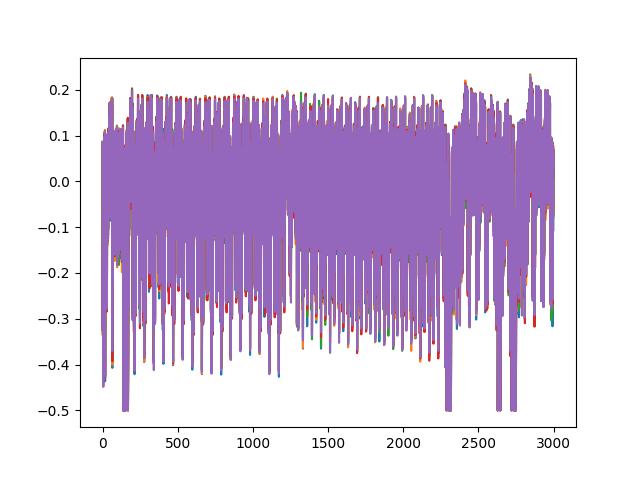

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for i in range(5):
    plt.plot(projects[0].waves[i])
    
plt.show()

## Analysis

In [5]:
import chipwhisperer as cw
projects = []
for i in range(4):
    project = cw.open_project(f"Var_Vec_{i}")
    projects.append(project)

In [6]:
from chipwhisperer.analyzer.attacks.attack_mix_columns import AttackMixColumns
attack = AttackMixColumns(projects)
results = attack.run()

c:\users\gc_lu\chipwh~1\cw\home\portable\chipwhisperer\software\chipwhisperer\analyzer\attacks\attack_mix_columns.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: divide by zero encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
print(bytearray(results["guess"]))
print(bytearray(projects[0].keys[0]))

CWbytearray(b'd1 7e 15 16 a5 ae d2 a6 79 f7 15 88 8b cf 4f 3c')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


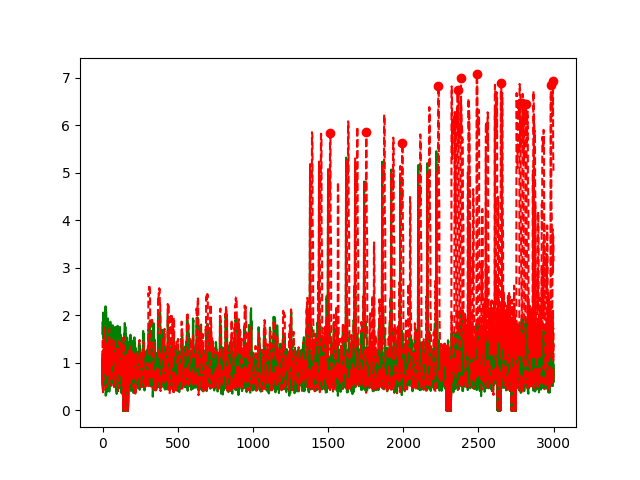

Best guess 0xd1 (corr=1.671416163444519), next best = 1.654436707496643, real = 1.3544896841049194
Best guess 0x7e (corr=6.894381046295166), next best = 4.845656871795654, real = 6.894381046295166
Best guess 0x15 (corr=6.922571182250977), next best = 4.744548797607422, real = 6.922571182250977
Best guess 0x16 (corr=5.842138767242432), next best = 5.030840873718262, real = 5.842138767242432
Best guess 0xa5 (corr=1.9861053228378296), next best = 1.8363233804702759, real = 1.7704980373382568
Best guess 0xae (corr=6.749268054962158), next best = 5.317974090576172, real = 6.749268054962158
Best guess 0xd2 (corr=6.463672637939453), next best = 5.123207092285156, real = 6.463672637939453
Best guess 0xa6 (corr=5.859199523925781), next best = 4.813848972320557, real = 5.859199523925781
Best guess 0x79 (corr=1.5347236394882202), next best = 1.4847818613052368, real = 1.2500954866409302
Best guess 0xf7 (corr=7.067079067230225), next best = 5.231234550476074, real = 7.067079067230225
Best guess 0x

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
for i in range(16):
    c = results["corr"][i]
    maxes = np.max(c, axis=1)
    guess = np.argsort(maxes)[-1]
    guess2 = np.argsort(maxes)[-2]
    actual = projects[0].keys[0][i]
    x = np.argmax(c[actual])
    if guess != actual:
        plt.plot(c[guess], "g-")
    else:
        plt.plot(c[guess2], "g-")
    plt.plot(c[actual], "r--")
    plt.plot(x, c[actual][x], "ro")
    print(f"Best guess {hex(guess)} (corr={maxes[guess]}), next best = {maxes[guess2]}, real = {maxes[actual]}")
plt.show()

## Original Implementations

Provided for reference.

In [9]:
%%time
import scared
import numpy as np
b = None
gal2=np.array((
0x00,0x02,0x04,0x06,0x08,0x0a,0x0c,0x0e,0x10,0x12,0x14,0x16,0x18,0x1a,0x1c,0x1e,
0x20,0x22,0x24,0x26,0x28,0x2a,0x2c,0x2e,0x30,0x32,0x34,0x36,0x38,0x3a,0x3c,0x3e,
0x40,0x42,0x44,0x46,0x48,0x4a,0x4c,0x4e,0x50,0x52,0x54,0x56,0x58,0x5a,0x5c,0x5e,
0x60,0x62,0x64,0x66,0x68,0x6a,0x6c,0x6e,0x70,0x72,0x74,0x76,0x78,0x7a,0x7c,0x7e,
0x80,0x82,0x84,0x86,0x88,0x8a,0x8c,0x8e,0x90,0x92,0x94,0x96,0x98,0x9a,0x9c,0x9e,
0xa0,0xa2,0xa4,0xa6,0xa8,0xaa,0xac,0xae,0xb0,0xb2,0xb4,0xb6,0xb8,0xba,0xbc,0xbe,
0xc0,0xc2,0xc4,0xc6,0xc8,0xca,0xcc,0xce,0xd0,0xd2,0xd4,0xd6,0xd8,0xda,0xdc,0xde,
0xe0,0xe2,0xe4,0xe6,0xe8,0xea,0xec,0xee,0xf0,0xf2,0xf4,0xf6,0xf8,0xfa,0xfc,0xfe,
0x1b,0x19,0x1f,0x1d,0x13,0x11,0x17,0x15,0x0b,0x09,0x0f,0x0d,0x03,0x01,0x07,0x05,
0x3b,0x39,0x3f,0x3d,0x33,0x31,0x37,0x35,0x2b,0x29,0x2f,0x2d,0x23,0x21,0x27,0x25,
0x5b,0x59,0x5f,0x5d,0x53,0x51,0x57,0x55,0x4b,0x49,0x4f,0x4d,0x43,0x41,0x47,0x45,
0x7b,0x79,0x7f,0x7d,0x73,0x71,0x77,0x75,0x6b,0x69,0x6f,0x6d,0x63,0x61,0x67,0x65,
0x9b,0x99,0x9f,0x9d,0x93,0x91,0x97,0x95,0x8b,0x89,0x8f,0x8d,0x83,0x81,0x87,0x85,
0xbb,0xb9,0xbf,0xbd,0xb3,0xb1,0xb7,0xb5,0xab,0xa9,0xaf,0xad,0xa3,0xa1,0xa7,0xa5,
0xdb,0xd9,0xdf,0xdd,0xd3,0xd1,0xd7,0xd5,0xcb,0xc9,0xcf,0xcd,0xc3,0xc1,0xc7,0xc5,
0xfb,0xf9,0xff,0xfd,0xf3,0xf1,0xf7,0xf5,0xeb,0xe9,0xef,0xed,0xe3,0xe1,0xe7,0xe5), dtype='uint8')

gal3=np.array((
0x00,0x03,0x06,0x05,0x0c,0x0f,0x0a,0x09,0x18,0x1b,0x1e,0x1d,0x14,0x17,0x12,0x11,
0x30,0x33,0x36,0x35,0x3c,0x3f,0x3a,0x39,0x28,0x2b,0x2e,0x2d,0x24,0x27,0x22,0x21,
0x60,0x63,0x66,0x65,0x6c,0x6f,0x6a,0x69,0x78,0x7b,0x7e,0x7d,0x74,0x77,0x72,0x71,
0x50,0x53,0x56,0x55,0x5c,0x5f,0x5a,0x59,0x48,0x4b,0x4e,0x4d,0x44,0x47,0x42,0x41,
0xc0,0xc3,0xc6,0xc5,0xcc,0xcf,0xca,0xc9,0xd8,0xdb,0xde,0xdd,0xd4,0xd7,0xd2,0xd1,
0xf0,0xf3,0xf6,0xf5,0xfc,0xff,0xfa,0xf9,0xe8,0xeb,0xee,0xed,0xe4,0xe7,0xe2,0xe1,
0xa0,0xa3,0xa6,0xa5,0xac,0xaf,0xaa,0xa9,0xb8,0xbb,0xbe,0xbd,0xb4,0xb7,0xb2,0xb1,
0x90,0x93,0x96,0x95,0x9c,0x9f,0x9a,0x99,0x88,0x8b,0x8e,0x8d,0x84,0x87,0x82,0x81,
0x9b,0x98,0x9d,0x9e,0x97,0x94,0x91,0x92,0x83,0x80,0x85,0x86,0x8f,0x8c,0x89,0x8a,
0xab,0xa8,0xad,0xae,0xa7,0xa4,0xa1,0xa2,0xb3,0xb0,0xb5,0xb6,0xbf,0xbc,0xb9,0xba,
0xfb,0xf8,0xfd,0xfe,0xf7,0xf4,0xf1,0xf2,0xe3,0xe0,0xe5,0xe6,0xef,0xec,0xe9,0xea,
0xcb,0xc8,0xcd,0xce,0xc7,0xc4,0xc1,0xc2,0xd3,0xd0,0xd5,0xd6,0xdf,0xdc,0xd9,0xda,
0x5b,0x58,0x5d,0x5e,0x57,0x54,0x51,0x52,0x43,0x40,0x45,0x46,0x4f,0x4c,0x49,0x4a,
0x6b,0x68,0x6d,0x6e,0x67,0x64,0x61,0x62,0x73,0x70,0x75,0x76,0x7f,0x7c,0x79,0x7a,
0x3b,0x38,0x3d,0x3e,0x37,0x34,0x31,0x32,0x23,0x20,0x25,0x26,0x2f,0x2c,0x29,0x2a,
0x0b,0x08,0x0d,0x0e,0x07,0x04,0x01,0x02,0x13,0x10,0x15,0x16,0x1f,0x1c,0x19,0x1a), dtype='uint8')



w=0x00
lut_input = [[0, 1, 2, 3],
        [4, 5, 6, 7],
        [8, 9, 10, 11],
        [12, 13, 14, 15]]

def round_gen_0(plaintext, guesses, cmpgn):
    lut_mix_column = [[0, 13, 10, 7],
                     [4, 1, 14, 11],
                     [8, 5, 2, 15],
                     [12, 9, 6, 3]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, gal2[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

def round_gen_1(plaintext, guesses, cmpgn):
    lut_mix_column = [[1, 14, 11, 4],
                     [5, 2, 15, 8],
                     [9, 6, 3, 12],
                     [13, 10, 7, 0]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_2(plaintext, guesses, cmpgn):
    lut_mix_column = [[2, 15, 8, 5],
                     [6, 3, 12, 9],
                     [10, 7, 0, 13],
                     [14, 1, 4, 1]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_3(plaintext, guesses, cmpgn):
    lut_mix_column = [[3, 12, 9, 6],
                     [7, 0, 13, 10],
                     [11, 4, 14, 1],
                     [15, 8, 5, 2]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(0, gal3[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

leakage_cmpgns = []
for campaign in range(4):
    leakage_cmpgns.append([scared.attack_selection_function(lambda plaintext, guesses: round_gen_0(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_1(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_2(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_3(plaintext, guesses, campaign))])

Wall time: 999 µs


C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
import tqdm.autonotebook

<IPython.core.display.Javascript object>


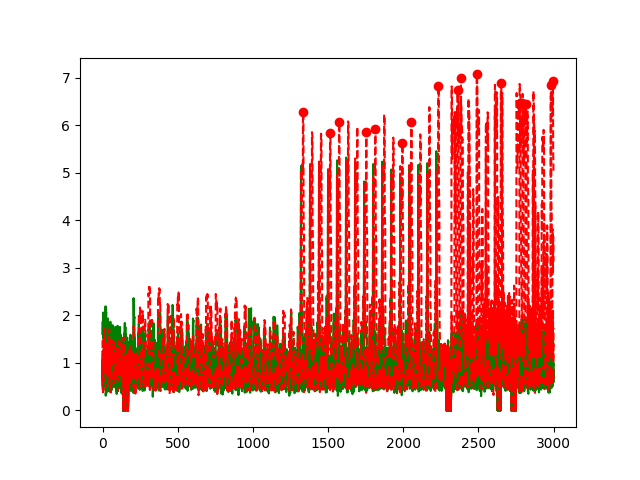

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: divide by zero encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0x2b (corr=6.27242374420166), next best = 5.141501426696777, real = 6.27242374420166
Best guess 0x7e (corr=6.894380569458008), next best = 4.8456573486328125, real = 6.894380569458008
Best guess 0x15 (corr=6.922570705413818), next best = 4.74454927444458, real = 6.922570705413818
Best guess 0x16 (corr=5.842138290405273), next best = 5.030839920043945, real = 5.842138290405273


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: divide by zero encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0x28 (corr=6.061622619628906), next best = 5.259405136108398, real = 6.061622619628906
Best guess 0xae (corr=6.749268531799316), next best = 5.317973613739014, real = 6.749268531799316
Best guess 0xd2 (corr=6.463672161102295), next best = 5.123206615447998, real = 6.463672161102295
Best guess 0xa6 (corr=5.859199047088623), next best = 4.813848972320557, real = 5.859199047088623


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: divide by zero encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0xab (corr=5.920042037963867), next best = 5.181880474090576, real = 5.920042037963867
Best guess 0xf7 (corr=7.067079067230225), next best = 5.231234550476074, real = 7.067079067230225
Best guess 0x15 (corr=6.848073959350586), next best = 5.066684246063232, real = 6.848073959350586
Best guess 0x88 (corr=5.6202521324157715), next best = 4.844135761260986, real = 5.6202521324157715


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: invalid value encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\distinguishers\cpa.py:53: RuntimeWarning: divide by zero encountered in true_divide
  tmp_result = (xy - (self.ex * (y / self.processed_traces))) / (common_1 * com_2)
C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\scared\discriminants.py:64: RuntimeWarning: All-NaN slice encountered
  return _np.nanmax(_np.absolute(data), axis=axis)


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best guess 0x9 (corr=6.065608024597168), next best = 5.14576530456543, real = 6.065608024597168
Best guess 0xcf (corr=6.9886040687561035), next best = 5.162285804748535, real = 6.9886040687561035
Best guess 0x4f (corr=6.453986167907715), next best = 5.201466083526611, real = 6.453986167907715
Best guess 0x3c (corr=6.817233562469482), next best = 5.453393936157227, real = 6.817233562469482


In [11]:
import estraces, scared
import numpy as np
from tqdm.notebook import trange
#del cw_traces
campaign = 0
n_traces = 10000
key_guess = []
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
    


for campaign in trange(0,4):
    b = None
    cw_traces = estraces.read_ths_from_ram(np.array(projects[campaign].waves)[:n_traces,:], 
                                      plaintext=np.array([textin for textin in projects[campaign].textins], dtype='uint8')[:n_traces])
    #cw_traces = estraces.read_ths_from_ram(np.array(projects[campaign].waves)[:n_traces,550:900], 
    #                                  plaintext=np.array([textin for textin in projects[campaign].textins], dtype='uint8')[:n_traces])
    for t in trange(4, leave=False):
        for i in trange(8, leave=False):
            container = scared.Container(cw_traces)
            a = scared.CPAAttack(selection_function=leakage_cmpgns[campaign][t],
                                model=scared.Monobit(i),
                                discriminant=scared.maxabs)


            a.run(container)
            if b is None:
                b = abs(a.results)
            else:
                b += abs(a.results)
    for i in range(0+4*campaign, 4+4*campaign):
        c = np.nan_to_num(b[:,i,:])
        maxes = np.max(c, axis=1)
        guess = np.argsort(maxes)[-1]
        guess2 = np.argsort(maxes)[-2]
        actual = projects[0].keys[0][i]
        x = np.argmax(c[actual])
        if guess != actual:
            plt.plot(c[guess], "g-")
        else:
            plt.plot(c[guess2], "g-")
        plt.plot(c[actual], "r--")
        plt.plot(x, c[actual][x], "ro")
        print(f"Best guess {hex(guess)} (corr={maxes[guess]}), next best = {maxes[guess2]}, real = {maxes[actual]}")
        key_guess.append(guess)

plt.show()

In [12]:
print(bytearray(key_guess))
print(bytearray(projects[0].keys[0]))

CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


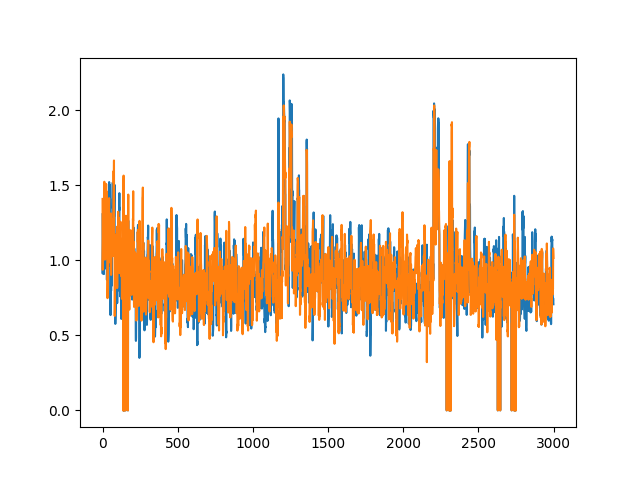

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(c[0x16])
plt.plot(c[0x7f])
    
plt.show()

C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


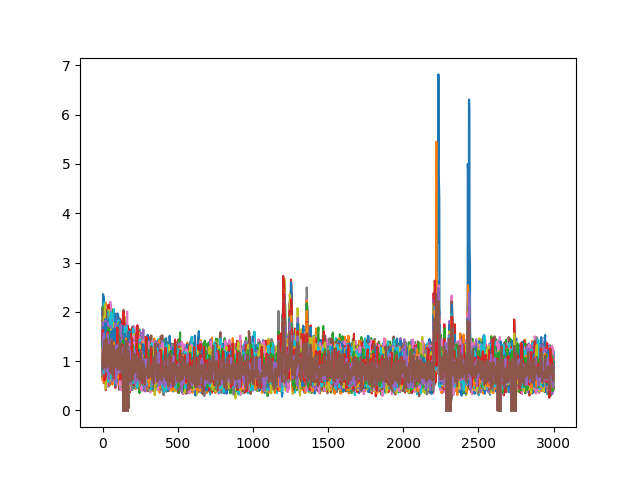

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for i in range(256):
    plt.plot(c[i])
    
plt.show()

In [15]:
%%time
import scared
import numpy as np
gal2=np.array((
0x00,0x02,0x04,0x06,0x08,0x0a,0x0c,0x0e,0x10,0x12,0x14,0x16,0x18,0x1a,0x1c,0x1e,
0x20,0x22,0x24,0x26,0x28,0x2a,0x2c,0x2e,0x30,0x32,0x34,0x36,0x38,0x3a,0x3c,0x3e,
0x40,0x42,0x44,0x46,0x48,0x4a,0x4c,0x4e,0x50,0x52,0x54,0x56,0x58,0x5a,0x5c,0x5e,
0x60,0x62,0x64,0x66,0x68,0x6a,0x6c,0x6e,0x70,0x72,0x74,0x76,0x78,0x7a,0x7c,0x7e,
0x80,0x82,0x84,0x86,0x88,0x8a,0x8c,0x8e,0x90,0x92,0x94,0x96,0x98,0x9a,0x9c,0x9e,
0xa0,0xa2,0xa4,0xa6,0xa8,0xaa,0xac,0xae,0xb0,0xb2,0xb4,0xb6,0xb8,0xba,0xbc,0xbe,
0xc0,0xc2,0xc4,0xc6,0xc8,0xca,0xcc,0xce,0xd0,0xd2,0xd4,0xd6,0xd8,0xda,0xdc,0xde,
0xe0,0xe2,0xe4,0xe6,0xe8,0xea,0xec,0xee,0xf0,0xf2,0xf4,0xf6,0xf8,0xfa,0xfc,0xfe,
0x1b,0x19,0x1f,0x1d,0x13,0x11,0x17,0x15,0x0b,0x09,0x0f,0x0d,0x03,0x01,0x07,0x05,
0x3b,0x39,0x3f,0x3d,0x33,0x31,0x37,0x35,0x2b,0x29,0x2f,0x2d,0x23,0x21,0x27,0x25,
0x5b,0x59,0x5f,0x5d,0x53,0x51,0x57,0x55,0x4b,0x49,0x4f,0x4d,0x43,0x41,0x47,0x45,
0x7b,0x79,0x7f,0x7d,0x73,0x71,0x77,0x75,0x6b,0x69,0x6f,0x6d,0x63,0x61,0x67,0x65,
0x9b,0x99,0x9f,0x9d,0x93,0x91,0x97,0x95,0x8b,0x89,0x8f,0x8d,0x83,0x81,0x87,0x85,
0xbb,0xb9,0xbf,0xbd,0xb3,0xb1,0xb7,0xb5,0xab,0xa9,0xaf,0xad,0xa3,0xa1,0xa7,0xa5,
0xdb,0xd9,0xdf,0xdd,0xd3,0xd1,0xd7,0xd5,0xcb,0xc9,0xcf,0xcd,0xc3,0xc1,0xc7,0xc5,
0xfb,0xf9,0xff,0xfd,0xf3,0xf1,0xf7,0xf5,0xeb,0xe9,0xef,0xed,0xe3,0xe1,0xe7,0xe5), dtype='uint8')

gal3=np.array((
0x00,0x03,0x06,0x05,0x0c,0x0f,0x0a,0x09,0x18,0x1b,0x1e,0x1d,0x14,0x17,0x12,0x11,
0x30,0x33,0x36,0x35,0x3c,0x3f,0x3a,0x39,0x28,0x2b,0x2e,0x2d,0x24,0x27,0x22,0x21,
0x60,0x63,0x66,0x65,0x6c,0x6f,0x6a,0x69,0x78,0x7b,0x7e,0x7d,0x74,0x77,0x72,0x71,
0x50,0x53,0x56,0x55,0x5c,0x5f,0x5a,0x59,0x48,0x4b,0x4e,0x4d,0x44,0x47,0x42,0x41,
0xc0,0xc3,0xc6,0xc5,0xcc,0xcf,0xca,0xc9,0xd8,0xdb,0xde,0xdd,0xd4,0xd7,0xd2,0xd1,
0xf0,0xf3,0xf6,0xf5,0xfc,0xff,0xfa,0xf9,0xe8,0xeb,0xee,0xed,0xe4,0xe7,0xe2,0xe1,
0xa0,0xa3,0xa6,0xa5,0xac,0xaf,0xaa,0xa9,0xb8,0xbb,0xbe,0xbd,0xb4,0xb7,0xb2,0xb1,
0x90,0x93,0x96,0x95,0x9c,0x9f,0x9a,0x99,0x88,0x8b,0x8e,0x8d,0x84,0x87,0x82,0x81,
0x9b,0x98,0x9d,0x9e,0x97,0x94,0x91,0x92,0x83,0x80,0x85,0x86,0x8f,0x8c,0x89,0x8a,
0xab,0xa8,0xad,0xae,0xa7,0xa4,0xa1,0xa2,0xb3,0xb0,0xb5,0xb6,0xbf,0xbc,0xb9,0xba,
0xfb,0xf8,0xfd,0xfe,0xf7,0xf4,0xf1,0xf2,0xe3,0xe0,0xe5,0xe6,0xef,0xec,0xe9,0xea,
0xcb,0xc8,0xcd,0xce,0xc7,0xc4,0xc1,0xc2,0xd3,0xd0,0xd5,0xd6,0xdf,0xdc,0xd9,0xda,
0x5b,0x58,0x5d,0x5e,0x57,0x54,0x51,0x52,0x43,0x40,0x45,0x46,0x4f,0x4c,0x49,0x4a,
0x6b,0x68,0x6d,0x6e,0x67,0x64,0x61,0x62,0x73,0x70,0x75,0x76,0x7f,0x7c,0x79,0x7a,
0x3b,0x38,0x3d,0x3e,0x37,0x34,0x31,0x32,0x23,0x20,0x25,0x26,0x2f,0x2c,0x29,0x2a,
0x0b,0x08,0x0d,0x0e,0x07,0x04,0x01,0x02,0x13,0x10,0x15,0x16,0x1f,0x1c,0x19,0x1a), dtype='uint8')



w=0x00
lut_input = [[0, 1, 2, 3],
        [4, 5, 6, 7],
        [8, 9, 10, 11],
        [12, 13, 14, 15]]

def round_gen_0(plaintext, guesses, cmpgn):
    lut_mix_column = [[0, 4, 8, 12],
                     [13, 1, 5, 9],
                     [10, 14, 2, 6],
                     [7, 11, 15, 3]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, gal2[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

def round_gen_1(plaintext, guesses, cmpgn):
    lut_mix_column = [[1, 5, 9, 13],
                     [14, 2, 6, 10],
                     [11, 15, 3, 7],
                     [4, 8, 12, 0]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_2(plaintext, guesses, cmpgn):
    lut_mix_column = [[2, 6, 10, 14],
                     [15, 3, 7, 11],
                     [8, 12, 0, 4],
                     [5, 9, 13, 1]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess)))
    return res

def round_gen_3(plaintext, guesses, cmpgn):
    lut_mix_column = [[3, 7, 11, 15],
                     [12, 0, 4, 8],
                     [9, 13, 1, 5],
                     [6, 10, 14, 2]] # lut to find which pt to xor with mixcolumn output
    res = np.empty((plaintext.shape[0], len(guesses), plaintext.shape[1]), dtype='uint8')
    new_pt = np.repeat(plaintext[:,lut_mix_column[cmpgn][0]][:, np.newaxis], 16, axis=1)
    new_pt[:,lut_input[cmpgn][1]] = plaintext[:,lut_mix_column[cmpgn][1]]
    new_pt[:,lut_input[cmpgn][2]] = plaintext[:,lut_mix_column[cmpgn][2]]
    new_pt[:,lut_input[cmpgn][3]] = plaintext[:,lut_mix_column[cmpgn][3]]
    for i, guess in enumerate(guesses):
        res[:,i,:] = np.bitwise_xor(new_pt, gal3[scared.aes.sub_bytes(np.bitwise_xor(plaintext, guess))])
    return res

leakage_cmpgns = []
for campaign in range(4):
    leakage_cmpgns.append([scared.attack_selection_function(lambda plaintext, guesses: round_gen_0(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_1(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_2(plaintext, guesses, campaign)),
    scared.attack_selection_function(lambda plaintext, guesses: round_gen_3(plaintext, guesses, campaign))])

Wall time: 999 µs


C:\Users\GC_Lu\CHIPWH~1\cw\home\portable\WPy64-3771\python-3.7.7.amd64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
